In [15]:
with open("../result.txt", "r") as file:
  lines = file.readlines()
mse, mae, rse, tg = [], [], [], []
for line in lines:
  if 'tg' in line:
    # print(line)
    tg.append(line.split('tg')[1].split('_')[0])
  if 'mse' in line:
    mse.append(round(float(line.split('mse:')[1].split(',')[0]), 3))
  if 'mae' in line:
    mae.append(round(float(line.split('mae:')[1].split(',')[0]), 3))
  if 'rse' in line:
    rse.append(round(float(line.split('rse:')[1].split(',')[0]), 3))

In [16]:
import pandas as pd
import numpy as np

idx = ['96', '192', '336', '720']
cols = list(dict.fromkeys(tg))

def plot_model_perf(error_type: str, error_list: list[float], idx_list: list[str]):
  x = np.reshape(error_list, (int(len(error_list)/len(idx)), len(idx_list))).T
  df = pd.DataFrame(x, columns=cols, index=idx_list)
  print(df)
  df.plot(style='--', marker='o', mfc='none', xlabel='Sequence Length', ylabel=error_type).legend(loc='upper right')

        OT      0     10     20     30     40     50     60     70
96   0.297  0.239  0.135  0.325  0.213  0.113  0.573  0.153  0.268
192  0.152  0.239  0.109  0.264  0.184  0.077  0.384  0.118  0.222
336  0.140  0.242  0.105  0.260  0.188  0.074  0.360  0.110  0.207
720  0.127  0.261  0.101  0.269  0.190  0.069  0.343  0.104  0.209


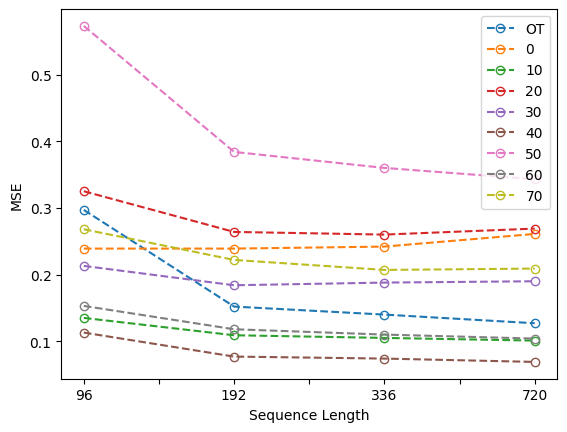

In [17]:
plot_model_perf('MSE', mse, idx)

        OT      0     10     20     30     40     50     60     70
96   0.397  0.248  0.268  0.393  0.309  0.249  0.591  0.289  0.360
192  0.277  0.266  0.244  0.351  0.283  0.205  0.470  0.252  0.329
336  0.264  0.260  0.239  0.348  0.287  0.200  0.451  0.242  0.321
720  0.252  0.288  0.236  0.355  0.290  0.195  0.437  0.235  0.323


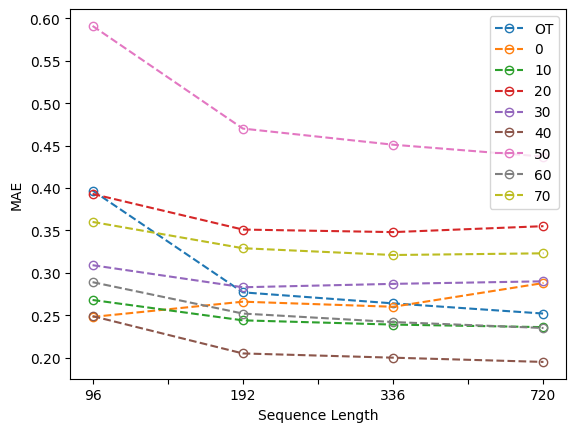

In [18]:
plot_model_perf('MAE', mae, idx)

        OT      0     10     20     30     40     50     60     70
96   0.533  0.495  0.474  0.480  0.489  0.384  0.744  0.408  0.552
192  0.381  0.495  0.426  0.432  0.454  0.317  0.609  0.358  0.502
336  0.366  0.497  0.417  0.429  0.460  0.310  0.590  0.345  0.484
720  0.349  0.517  0.411  0.436  0.462  0.300  0.576  0.336  0.487


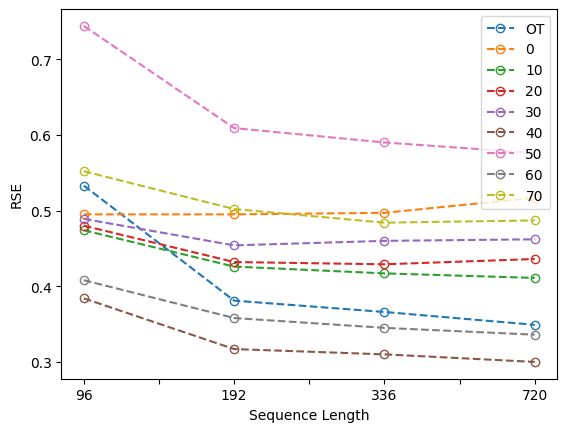

In [19]:
plot_model_perf('RSE', rse, idx)